Convolutional Pose Machines (for Cloth Landmark) Python Demo Code

In [40]:
# -----IMPORT LIBS-----
import os
import cv2 as cv 
import numpy as np
import scipy
import PIL.Image
import math
import caffe
import time
from config_reader import config_reader
import util
import copy

In [41]:
# -----WORKING DIR-----
project_dir = '/tanfulun/workspaces/Project/clothing_key_point_detection/convolutional-pose-machines-release'

In [42]:
# -----GET TESTING IMAGE-----
ds = 'test'
# --get candidate image from testset
dataset_dir = os.path.join(project_dir,'dataset','DeepfashionLandmark')
testset_file = os.path.join(dataset_dir,'%s.txt'%ds)
testset_lmdb_dir = os.path.join(dataset_dir,'lmdb','%s'%ds)

# --"Random" or "Mannual" Select a testing image
TEST_IMAGE_SELECT_TYPE = 'Random'    # 'Mannual' or 'Random'

f = open(testset_file,'r')
test_image_name = f.readlines()
f.close()

test_image_name = [x.strip() for x in test_image_name]
numSample = len(test_image_name)

# randomize
random_order = np.random.permutation(numSample).tolist()

if TEST_IMAGE_SELECT_TYPE == 'Mannual':
    target_image_idx = 30229
else:
    target_image_idx = random_order[0]

target_image_name = test_image_name[target_image_idx]


#test_image = '../sample_image/frame0181.png'
#test_image = '../sample_image/FLIC_test/princess-diaries-2-00152201.jpg'
#img = np.float32(PIL.Image.open(test_image))
#util.showBGRimage(img)

In [43]:

print target_image_idx

14366


0014366,0


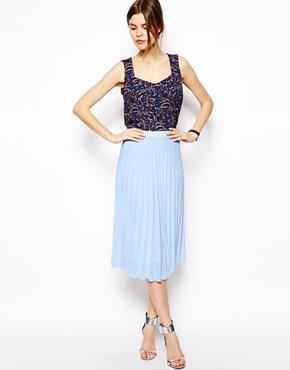

Dataset Name:DeepFashion_Landmark
Objpos: x--147.000000, y--198.000000


In [44]:
# -----Explore LMDB-----
import lmdb
from caffe.proto import caffe_pb2
import struct
import pdb

# --LMDB parsing
lmdb_dir = testset_lmdb_dir

lmdb_env = lmdb.open(lmdb_dir)
lmdb_txn = lmdb_env.begin()
lmdb_cursor = lmdb_txn.cursor()
datum = caffe_pb2.Datum()

# --get target image and annotatin info
key = '%07d' % target_image_idx

value = lmdb_txn.get(key)
datum.ParseFromString(value)

label = datum.label
data = caffe.io.datum_to_array(datum)
    
print('{},{}'.format(key, label))

if data.shape[0]==4:
    # split "image" and "annotation info"
    image_data = data[0:3]
    anno_info = data[3]
else:
    image_data = data


#CxHxW to HxWxC in cv2
image = np.transpose(image_data, (1,2,0))
util.showBGRimage(image)
    
# --parsing anno info

# row1, dataset_name
data_ascii = anno_info[0,:]
str_end_idx = len(data_ascii)-1
for i in range(str_end_idx,-1,-1):
    if data_ascii[i]==0:
        continue
    else:
        str_end_idx = i
        break
dataset_name = ''.join(chr(item) for item in data_ascii[0:str_end_idx+1])
print('Dataset Name:%s'%dataset_name)
    
# row4, (b) objpos_x (float), objpos_y (float)
data_str = anno_info[3,0:8]
data_ascii = [chr(item) for item in data_str]
data_ascii_join = ''.join(data_ascii)

objpos_x, = struct.unpack('f',data_ascii_join[0:4])
objpos_y, = struct.unpack('f',data_ascii_join[4:8])

print('Objpos: x--%f, y--%f'%(objpos_x,objpos_y))

#show padded image


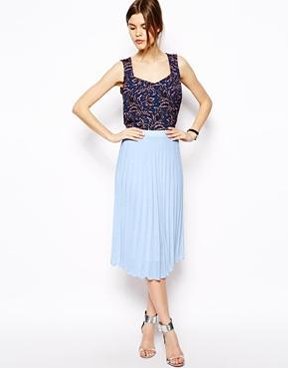

((368, 288, 3), [0, 0, 0, 0])


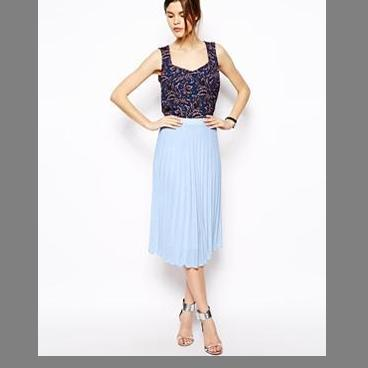

In [45]:
# -----PREPROCESS-----
num_clothes = 1
crop_width = 368
crop_height = 368
oriImg = image
cloth_pos_x = []
cloth_pos_y = []

# --Resize image "width" to "crop_width"
boxsize = crop_width
npart = 8
scale = boxsize/(oriImg.shape[0] * 1.0)
imageToTest = cv.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv.INTER_CUBIC)

# --Get cloth_pos
cloth_pos_x = [int(objpos_x * scale)]
cloth_pos_y = [int(objpos_y * scale)]

# --Padding RightDownCorner
# And because the network is downsizing the input image by 8x, 
# we need to pad the image (on the right and bottom) to make 
# its width and height be multiplies of 8.
imageToTest_padded, pad = util.padRightDownCorner(imageToTest)

print('#show padded image')
util.showBGRimage(imageToTest_padded, 'png')
print(imageToTest_padded.shape, pad)

# --Crop cloth
cloth_image = np.ones((crop_width, crop_height, 3, num_clothes)) * 128
for p in range(num_clothes):
    for x_p in range(crop_width):
        for y_p in range(crop_height):
            x_i = x_p - crop_width/2 + cloth_pos_x[p]
            y_i = y_p - crop_height/2 + cloth_pos_y[p]
            if x_i >= 0 and x_i < imageToTest.shape[1] and y_i >= 0 and y_i < imageToTest.shape[0]:
                cloth_image[y_p, x_p, :, p] = imageToTest[y_i, x_i, :]
# show one of them for inspection
util.showBGRimage(cloth_image[:,:,:,0])



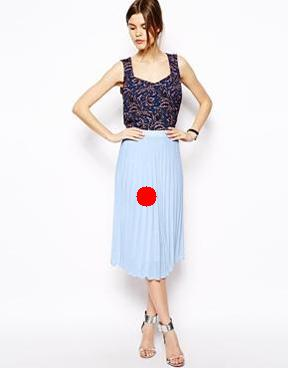

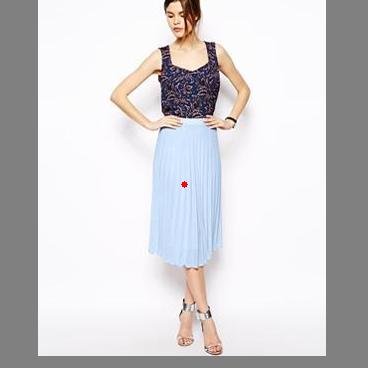

In [46]:
# -----Plot cloth_pos on image
imageToTest_padded_with_objpos = np.copy(imageToTest_padded)
cv.circle(imageToTest_padded_with_objpos, (cloth_pos_x[0], cloth_pos_y[0]), 10, (0,0,255), -1)
util.showBGRimage(imageToTest_padded_with_objpos)

cloth_img_with_objpos = np.copy(cloth_image[:,:,:,0])
cv.circle(cloth_img_with_objpos, (crop_width/2, crop_height/2), 3, (0,0,255), -1)
util.showBGRimage(cloth_img_with_objpos)


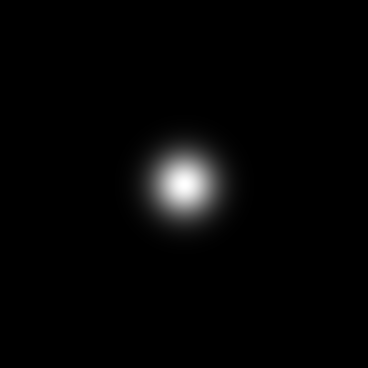

In [47]:
# -----GUSSIAN MAP-----
sigma = 21

gaussian_map = np.zeros((boxsize, boxsize))
for x_p in range(boxsize):
    for y_p in range(boxsize):
        dist_sq = (x_p - boxsize/2) * (x_p - boxsize/2) + \
                  (y_p - boxsize/2) * (y_p - boxsize/2)
        exponent = dist_sq / 2.0 / sigma / sigma
        gaussian_map[y_p, x_p] = math.exp(-exponent)
util.showmap(gaussian_map * 256)

In [48]:
caffe.set_mode_gpu()
caffe.set_device(0)

In [49]:
# -----TESTING-----
deployFile = '../../training/prototxt/DeepFashion_Landmark/pose_deploy.prototxt'
caffemodel = '../../training/prototxt/DeepFashion_Landmark/caffemodel/landmark_iter_24000.caffemodel'

pose_net = caffe.Net(deployFile, caffemodel, caffe.TEST)
pose_net.forward() # dry run to avoid GPU synchronization later in caffe
output_blobs_array = [dict() for dummy in range(num_clothes)]
for p in range(num_clothes):
    input_4ch = np.ones((boxsize, boxsize, 4))
    input_4ch[:,:,0:3] = cloth_image[:,:,:,p]/256.0 - 0.5 # normalize to [-0.5, 0.5]
    input_4ch[:,:,3] = gaussian_map
    pose_net.blobs['data'].data[...] = np.transpose(np.float32(input_4ch[:,:,:,np.newaxis]), (3,2,0,1))
    start_time = time.time()
    #output_blobs_array[p] = copy.deepcopy(pose_net.forward()['Mconv7_stage6'])
    output_blobs_array[p] = copy.deepcopy(pose_net.forward()['Mconv5_stage6'])
    print('For person %d, pose net took %.2f ms.' % (p, 1000 * (time.time() - start_time)))

For person 0, pose net took 73.49 ms.


In [50]:
print len(output_blobs_array)
#pdb.set_trace()
print(np.array(output_blobs_array).shape)

1
(1, 1, 19, 46, 46)


cloth 0


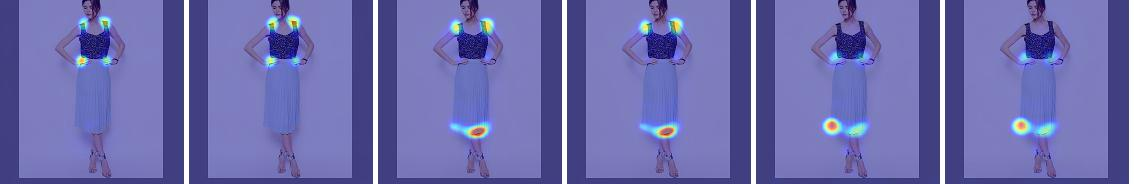

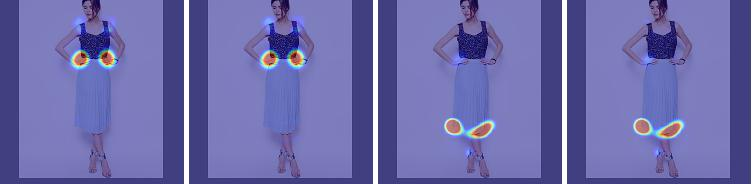

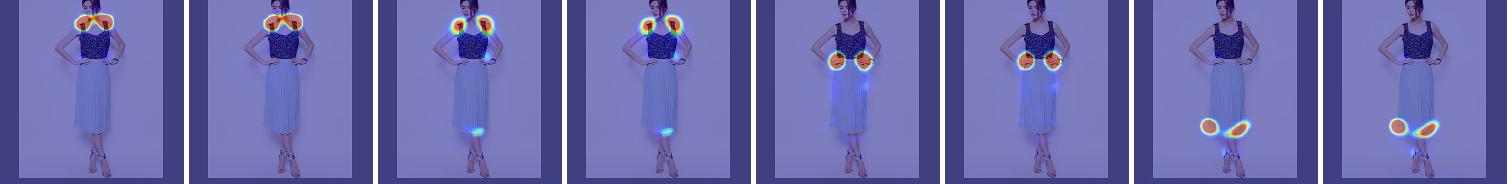

In [51]:
for p in range(num_clothes):
    print('cloth %d' % p)
    down_scaled_image = cv.resize(cloth_image[:,:,:,p], (0,0), fx=0.5, fy=0.5, interpolation=cv.INTER_CUBIC)
    canvas = np.empty(shape=(boxsize/2, 0, 3))
    
    show_body_parts = [0,3,7,10,12] # sample 5 body parts: [head, right elbow, left wrist, right ankle, left knee]
    
    upper_parts = [0,1,2,3,4,5]
    lower_parts = [6,7,8,9]
    full_parts = [10,11,12,13,14,15,16,17]
    
    pixel_reinforcement = 20
    
    # upper_parts
    show_body_parts = upper_parts
    
    for part in show_body_parts:
        part_map = output_blobs_array[p][0,part,:,:] * pixel_reinforcement
        part_map_resized = cv.resize(part_map, (0,0), fx=4, fy=4, interpolation=cv.INTER_CUBIC) #only for displaying
        part_map_color = util.colorize(part_map_resized)
        part_map_color_blend = part_map_color * 0.5 + down_scaled_image * 0.5
        
        canvas = np.concatenate((canvas, part_map_color_blend), axis=1)
        canvas = np.concatenate((canvas, 255 * np.ones((boxsize/2, 5, 3))), axis=1)
    util.showBGRimage(canvas)
    
    # lower_parts
    show_body_parts = lower_parts
    
    canvas = np.empty(shape=(boxsize/2, 0, 3))
    
    for part in show_body_parts:
        part_map = output_blobs_array[p][0,part,:,:] * pixel_reinforcement
        part_map_resized = cv.resize(part_map, (0,0), fx=4, fy=4, interpolation=cv.INTER_CUBIC) #only for displaying
        part_map_color = util.colorize(part_map_resized)
        part_map_color_blend = part_map_color * 0.5 + down_scaled_image * 0.5
        
        canvas = np.concatenate((canvas, part_map_color_blend), axis=1)
        canvas = np.concatenate((canvas, 255 * np.ones((boxsize/2, 5, 3))), axis=1)
    util.showBGRimage(canvas)
    
    # full_parts
    show_body_parts = full_parts
    
    canvas = np.empty(shape=(boxsize/2, 0, 3))
    
    for part in show_body_parts:
        part_map = output_blobs_array[p][0,part,:,:] * pixel_reinforcement
        part_map_resized = cv.resize(part_map, (0,0), fx=4, fy=4, interpolation=cv.INTER_CUBIC) #only for displaying
        part_map_color = util.colorize(part_map_resized)
        part_map_color_blend = part_map_color * 0.5 + down_scaled_image * 0.5
        
        canvas = np.concatenate((canvas, part_map_color_blend), axis=1)
        canvas = np.concatenate((canvas, 255 * np.ones((boxsize/2, 5, 3))), axis=1)
    util.showBGRimage(canvas)

cloth 0


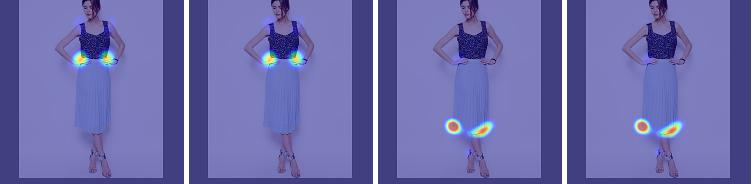

In [52]:


for p in range(num_clothes):
    print('cloth %d' % p)
    down_scaled_image = cv.resize(cloth_image[:,:,:,p], (0,0), fx=0.5, fy=0.5, interpolation=cv.INTER_CUBIC)
    canvas = np.empty(shape=(boxsize/2, 0, 3))
    
    show_body_parts = [0,3,7,10,12] # sample 5 body parts: [head, right elbow, left wrist, right ankle, left knee]
    
    upper_parts = [0,1,2,3,4,5]
    lower_parts = [6,7,8,9]
    full_parts = [10,11,12,13,14,15,16,17]
    
    show_body_parts = lower_parts
    
    for part in show_body_parts:
        part_map = output_blobs_array[p][0,part,:,:]*10
        part_map_resized = cv.resize(part_map, (0,0), fx=4, fy=4, interpolation=cv.INTER_CUBIC) #only for displaying
        part_map_color = util.colorize(part_map_resized)
        part_map_color_blend = part_map_color * 0.5 + down_scaled_image * 0.5
        
        canvas = np.concatenate((canvas, part_map_color_blend), axis=1)
        canvas = np.concatenate((canvas, 255 * np.ones((boxsize/2, 5, 3))), axis=1)
    util.showBGRimage(canvas)